In [1]:
using Pkg
Pkg.instantiate()

In [2]:
using GraphViz

using StockFlow
using StockFlow.Syntax

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

using Catlab.Graphics.Graphviz: Html
using Catlab.Graphics.Graphviz

In [3]:
# Functions for graphing typed Petri nets
colors_vflow = ["antiquewhite4","antiquewhite", "gold", "saddlebrown", "slateblue", "blueviolet", "olive"]
colors_s = ["deeppink","darkorchid","darkred","coral"] # red series
colors_sv = ["cornflowerblue","cyan4","cyan","chartreuse"] # green and blue series
colors_p = ["gold","gold4","darkorange1","lightgoldenrod","goldenrod"] # yellow and orange

flatten(fname::Symbol) = "$fname"

function flatten(fname::Tuple)
    names = split(replace(string(fname), "("=>"", ")"=>"", ":"=>""), ",")
    for i in 1:length(names)
        name = strip(names[i])
        if name[1:2] == "id"
            continue
        end
        return name
    end
    return "id"
end

def_stock(typed_StockFlow::ACSetTransformation, colors) = 
  (p,s) -> ("s$s", Attributes(:label=>sname(p,s) isa Tuple where T ? Html(replace(string(sname(p,s)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(sname(p,s))",
                                     :shape=>"square", 
                                     :color=>"black", 
                                     :style=>"filled", 
                                     :fillcolor=>colors[typed_StockFlow[:S](s)]))

def_parameter(typed_StockFlow::ACSetTransformation, colors) = 
(p, pp) -> ("p$pp", Attributes(:label=>pname(p,pp) isa Tuple where T ? Html(replace(string(pname(p,pp)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(pname(p,pp))",
                                     :shape=>"circle", 
                                     :color=>colors[typed_StockFlow[:P](pp)],
                                     :fontcolor=>colors[typed_StockFlow[:P](pp)]))

def_auxiliaryVF(typed_StockFlow::ACSetTransformation, colors)=
  (p, v) -> ("v$v", Attributes(:label=>make_v_expr(p,v) isa Tuple where T ? Html(replace(string(make_v_expr(p,v)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(make_v_expr(p,v))",
                                          :shape=>"plaintext", 
                                          :fontcolor=>colors[typed_StockFlow[:V](v)]))


def_sumV(typed_StockFlow::ACSetTransformation, colors) = 
  (p, sv) -> ("sv$sv", Attributes(:label=>svname(p,sv) isa Tuple where T ? Html(replace(string(svname(p,sv)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(svname(p,sv))",
                                       :shape=>"circle", 
                                       :color=>"black",
                                       :fillcolor=>colors[typed_StockFlow[:SV](sv)], 
                                       :style=>"filled"))  


def_flow_V(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[typed_StockFlow[:F](f)]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
end
        
def_flow_noneV(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, f) -> begin
     colorType = colors[typed_StockFlow[:F](f)]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

def_flow_V(colors = colors_vflow)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[f]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
    
end
        
def_flow_noneV(colors = colors_vflow)=
  (p, us, ds, f) -> begin
     colorType = colors[f]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

GraphF_typed(typed_StockFlow::ACSetTransformation, colors_vflow = colors_vflow, colors_s = colors_s, colors_p = colors_p, colors_sv = colors_sv; schema::String="C", type::String="SFVL", rd::String="LR") = GraphF(dom(typed_StockFlow),
    make_stock = def_stock(typed_StockFlow, colors_s), make_auxiliaryV=def_auxiliaryVF(typed_StockFlow, colors_vflow), make_sumV=def_sumV(typed_StockFlow, colors_sv), 
    make_flow_V=def_flow_V(typed_StockFlow, colors_vflow), make_flow_noneV=def_flow_noneV(typed_StockFlow, colors_vflow),make_parameter=def_parameter(typed_StockFlow, colors_p),schema=schema, type=type, rd=rd
)
            
flatten(k::Nothing) = "nothing"
            
            

flatten (generic function with 3 methods)

### 1.1 define the type stock and flow diagram (common part)

In [4]:
pop_type = @stock_and_flow begin
    :stocks
    pop
    
    :parameters
    μ
    δ
    
    β
    c

    rFstOrder
    rAge
    


    :dynamic_variables

    v_births = μ * N
    v_deaths = pop * δ



    v_prevalence = NI / NS
    v_meanInfectiousContactsPerS = c * v_prevalence
    
    v_perSIncidenceRate = β * v_meanInfectiousContactsPerS
    
    v_inf = pop * v_perSIncidenceRate

    
    v_fstOrder = pop * rFstOrder
    v_aging = pop * rAge


    
    :flows
    CLOUD => f_births(v_births) => pop
    pop => f_deaths(v_deaths) => CLOUD
    pop => f_inf(v_inf) => pop

    pop => f_fstOrder(v_fstOrder) => pop
    pop => f_aging(v_aging) => pop

    
    :sums
    N = [pop]
    NI = [pop] # connected to newInfectious (incid in SEIR )
    NS = [pop] # "
    
    
end

StockAndFlowF with elements S = 1:1, SV = 1:3, LS = 1:3, F = 1:5, I = 1:4, O = 1:4, V = 1:8, LV = 1:4, LSV = 1:3, P = 1:6, LVV = 1:3, LPV = 1:6
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │   pop │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │     NI │
│  3 │     NS │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   1 │    2 │
│  3 │   1 │    3 │
└────┴─────┴──────┘
┌───┬────┬────────────┐
│ F │ fv │      fname │
├───┼────┼────────────┤
│ 1 │  1 │   f_births │
│ 2 │  2 │   f_deaths │
│ 3 │  6 │      f_inf │
│ 4 │  7 │ f_fstOrder │
│ 5 │  8 │    f_aging │
└───┴────┴────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   3 │  1 │
│ 3 │   4 │  1 │
│ 4 │   5 │  1 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   3 │  1 │
│ 3 │   4 │  1 │
│ 4 │   5 │  1 │
└───┴─────┴────┘
┌───┬──────────────────────────────┬─────┐
│ V │                        vname │ vop │
├───┼──────────────────────────────┼─────┤
│ 1 │                     v_births │   * │
│ 2 │                     v_deaths │   * │
│ 3 │                 v_prevalence │   / │
│ 4 │ v_meanInfectiousContactsPerS │   * │
│ 5 │          v_perSIncidenceRate │   * │
│ 6 │                        v_inf │   * │
│ 7 │                   v_fstOrder │   * │
│ 8 │                      v_aging │   * │
└───┴──────────────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   2 │           1 │
│  2 │   1 │   6 │           1 │
│  3 │   1 │   7 │           1 │
│  4 │   1 │   8 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             2 │
│   2 │     2 │    3 │             1 │
│   3 │     3 │    3 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────────┐
│ P │     pname │
├───┼───────────┤
│ 1 │         μ │
│ 2 │         δ │
│ 3 │         β │
│ 4 │         c │
│ 5 │ rFstOrder │
│ 6 │      rAge │
└───┴───────────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     3 │     4 │             2 │
│   2 │     4 │     5 │             2 │
│   3 │     5 │     6 │             2 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    1 │            1 │
│   2 │    2 │    2 │            2 │
│   3 │    4 │    4 │            1 │
│   4 │    3 │    5 │            1 │
│   5 │    5 │    7 │            2 │
│   6 │    6 │    8 │            2 │
└─────┴──────┴──────┴──────────────┘

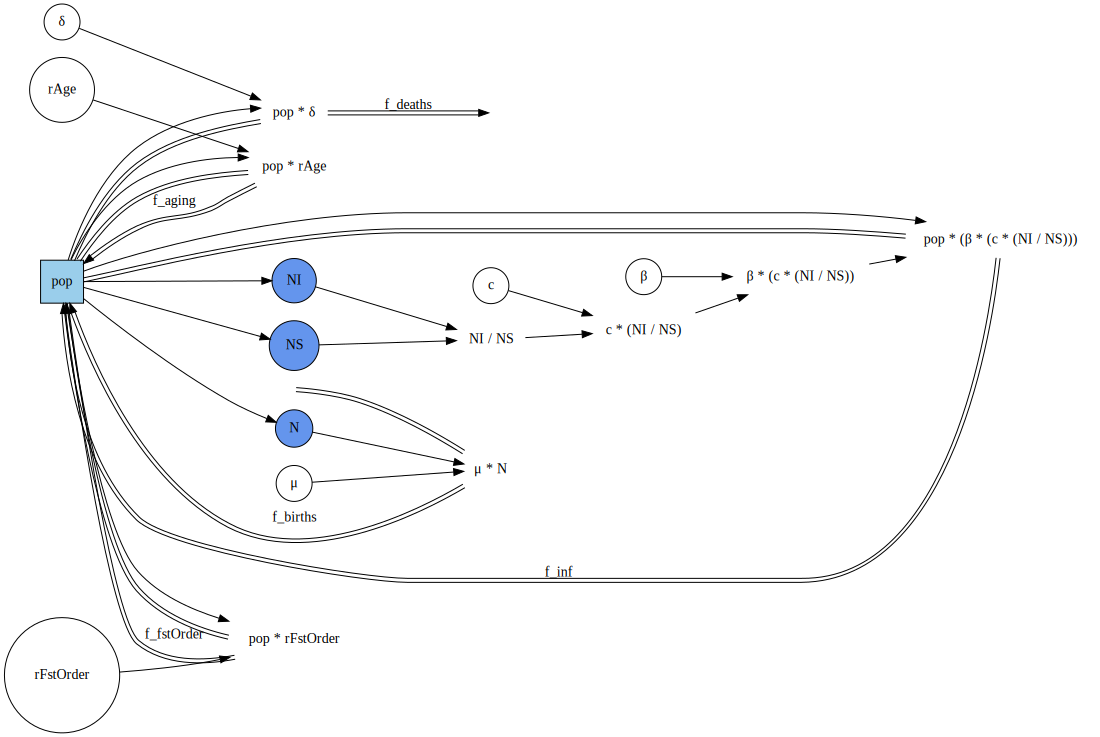

In [5]:
GraphF(pop_type)

In [6]:
# eliminate the attribute of name to enable pass the natural check
# only eliminate the name, the other two attributes should be okay
pop_type_noname = map(pop_type, Name=name->nothing, Op=op->nothing, Position=pos->nothing);

#### 1.1.1 Define the index name of each part

In [7]:
popstock, = parts(pop_type_noname, :S)
N, NI, NS = parts(pop_type_noname, :SV)
ls_N, ls_NI, ls_NS, = parts(pop_type_noname, :LS)
f_births, f_deaths, f_inf, f_fstOrder, f_aging = parts(pop_type_noname, :F)
i_births, i_inf, i_fstOrder, i_aging = parts(pop_type_noname, :I) # note, different order from previous in both inflow and outflow
o_deaths, o_inf, o_fstOrder, o_aging = parts(pop_type_noname, :O)
v_births, v_deaths, v_prevalence, v_meanInfectiousContactsPerS, v_perSIncidenceRate, v_inf, v_fstOrder, v_aging = parts(pop_type, :V)

lv_deaths, lv_inf, lv_fstOrder, lv_aging = parts(pop_type_noname, :LV)

lsv_births, lsv_prevalence_NI, lsv_prevalence_NS = parts(pop_type_noname, :LSV)

p_μ, p_δ, p_β, p_c, p_rFstOrder, p_rAge = parts(pop_type_noname, :P)
lvv_prevalence, lvv_meanInfectiousContactsPerS, lvv_perSIncidenceRate = parts(pop_type_noname, :LVV)
lpv_μ, lpv_δ, lpv_c, lpv_β, lpv_rFstOrder, lpv_rAge = parts(pop_type_noname, :LPV)

1:6

## 1.2 define SEIR model

In [8]:
seir = @stock_and_flow begin #todo: readd id flows
    :stocks
    S
    E
    I
    R

    :parameters
    μ
    β
    tlat
    trec
    δ
    c
    rage

    :dynamic_variables
    v_birth = μ * N
    v_inf = E * tlat # tlat = 1 / tlatent
    v_rec = I * trec # trec = 1 / trecovery


    
    v_prevalence = NI / NS
    v_meanInfectiousContactsPerS = c * v_prevalence
    v_perSIncidenceRate = β * v_meanInfectiousContactsPerS
    v_newInfections = S * v_perSIncidenceRate


    v_deathS = S * δ
    v_deathE = E * δ
    v_deathI = I * δ
    v_deathR = R * δ

    v_idS = S * rage
    v_idE = E * rage
    v_idI = I * rage
    v_idR = R * rage



    :flows
    CLOUD => f_birth(v_birth) => S
    S => f_incid(v_newInfections) => E
    S => f_deathS(v_deathS) => CLOUD
    E => f_inf(v_inf) => I
    E => f_deathE(v_deathE) => CLOUD
    I => f_rec(v_rec) => R
    I => f_deathI(v_deathI) => CLOUD
    R => f_deathR(v_deathR) => CLOUD

    S => f_idS(v_idS) => S
    E => f_idE(v_idE) => E
    I => f_idI(v_idI) => I
    R => f_idR(v_idR) => R




    :sums
    N = [S, E, I, R]
    NI = [I]
    NS = [S, E, I, R]

end




StockAndFlowF with elements S = 1:4, SV = 1:3, LS = 1:9, F = 1:12, I = 1:8, O = 1:11, V = 1:15, LV = 1:11, LSV = 1:3, P = 1:7, LVV = 1:3, LPV = 1:13
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     S │
│ 2 │     E │
│ 3 │     I │
│ 4 │     R │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │     NI │
│  3 │     NS │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   1 │    3 │
│  3 │   2 │    1 │
│  4 │   2 │    3 │
│  5 │   3 │    1 │
│  6 │   3 │    2 │
│  7 │   3 │    3 │
│  8 │   4 │    1 │
│  9 │   4 │    3 │
└────┴─────┴──────┘
┌────┬────┬──────────┐
│  F │ fv │    fname │
├────┼────┼──────────┤
│  1 │  1 │  f_birth │
│  2 │  7 │  f_incid │
│  3 │  8 │ f_deathS │
│  4 │  2 │    f_inf │
│  5 │  9 │ f_deathE │
│  6 │  3 │    f_rec │
│  7 │ 10 │ f_deathI │
│  8 │ 11 │ f_deathR │
│  9 │ 12 │    f_idS │
│ 10 │ 13 │    f_idE │
│ 11 │ 14 │    f_idI │
│ 12 │ 15 │    f_idR │
└────┴────┴──────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   9 │  1 │
│ 3 │   2 │  2 │
│ 4 │  10 │  2 │
│ 5 │   4 │  3 │
│ 6 │  11 │  3 │
│ 7 │   6 │  4 │
│ 8 │  12 │  4 │
└───┴─────┴────┘
┌────┬─────┬────┐
│  O │ ofn │ os │
├────┼─────┼────┤
│  1 │   2 │  1 │
│  2 │   3 │  1 │
│  3 │   9 │  1 │
│  4 │   4 │  2 │
│  5 │   5 │  2 │
│  6 │  10 │  2 │
│  7 │   6 │  3 │
│  8 │   7 │  3 │
│  9 │  11 │  3 │
│ 10 │   8 │  4 │
│ 11 │  12 │  4 │
└────┴─────┴────┘
┌────┬──────────────────────────────┬─────┐
│  V │                        vname │ vop │
├────┼──────────────────────────────┼─────┤
│  1 │                      v_birth │   * │
│  2 │                        v_inf │   * │
│  3 │                        v_rec │   * │
│  4 │                 v_prevalence │   / │
│  5 │ v_meanInfectiousContactsPerS │   * │
│  6 │          v_perSIncidenceRate │   * │
│  7 │              v_newInfections │   * │
│  8 │                     v_deathS │   * │
│  9 │                     v_deathE │   * │
│ 10 │                     v_deathI │   * │
│ 11 │                     v_deathR │   * │
│ 12 │                        v_idS │   * │
│ 13 │                        v_idE │   * │
│ 14 │                        v_idI │   * │
│ 15 │                        v_idR │   * │
└────┴──────────────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   2 │   2 │           1 │
│  2 │   3 │   3 │           1 │
│  3 │   1 │   7 │           1 │
│  4 │   1 │   8 │           1 │
│  5 │   2 │   9 │           1 │
│  6 │   3 │  10 │           1 │
│  7 │   4 │  11 │           1 │
│  8 │   1 │  12 │           1 │
│  9 │   2 │  13 │           1 │
│ 10 │   3 │  14 │           1 │
│ 11 │   4 │  15 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             2 │
│   2 │     2 │    4 │             1 │
│   3 │     3 │    4 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────┐
│ P │ pname │
├───┼───────┤
│ 1 │     μ │
│ 2 │     β │
│ 3 │  tlat │
│ 4 │  trec │
│ 5 │     δ │
│ 6 │     c │
│ 7 │  rage │
└───┴───────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     4 │     5 │             2 │
│   2 │     5 │     6 │             2 │
│   3 │     6 │     7 │             2 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    1 │            1 │
│   2 │    3 │    2 │            2 │
│   3 │    4 │    3 │            2 │
│   4 │    6 │    5 │            1 │
│   5 │    2 │    6 │            1 │
│   6 │    5 │    8 │            2 │
│   7 │    5 │    9 │            2 │
│   8 │    5 │   10 │            2 │
│   9 │    5 │   11 │            2 │
│  10 │    7 │   12 │            2 │
│  11 

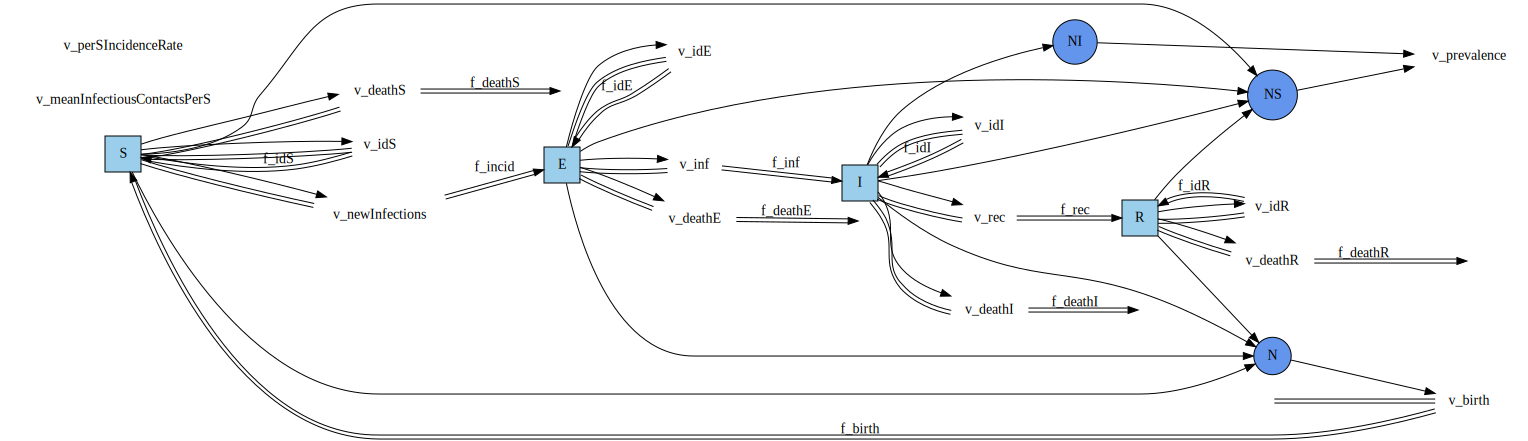

In [9]:
Graph(seir)

In [10]:
# seir = map(seir, Name=name->nothing, Op=op->nothing, Position=pos->nothing);

In [11]:
# popstock, = parts(pop_type, :S)
# N, NI, NS = parts(pop_type, :SV)
# ls_N, ls_NI, ls_NS, = parts(pop_type, :LS)
# f_births, f_deaths, f_inf, f_fstOrder, f_aging = parts(pop_type, :F)
# i_births, i_inf, i_fstOrder, i_aging = parts(pop_type, :I) # note, different order from previous in both inflow and outflow
# o_deaths, o_inf, o_fstOrder, o_aging = parts(pop_type, :O)
# v_births, v_deaths, v_prevalence, v_meanInfectiousContactsPerS, v_perSIncidenceRate, v_inf, v_fstOrder, v_aging = parts(pop_type, :V)

# lv_deaths, lv_inf, lv_fstOrder, lv_aging = parts(pop_type, :LV)

# lsv_births, lsv_prevalence_NI, lsv_prevalence_NS = parts(pop_type, :LSV)

# p_μ, p_δ, p_β, p_c, p_rFstOrder, p_rAge = parts(pop_type, :P)
# lvv_prevalence, lvv_meanInfectiousContactsPerS, lvv_perSIncidenceRate = parts(pop_type, :LVV)
# lpv_μ, lpv_δ, lpv_c, lpv_β, lpv_rFstOrder, lpv_rAge = parts(pop_type, :LPV)


typed_aggregate_model = ACSetTransformation(seir, pop_type_noname,
    S = [popstock, popstock, popstock, popstock],
    SV = [N, NI, NS],
    LS = [ls_N, ls_NS, ls_N, ls_NS, ls_N, ls_NI, ls_NS, ls_N, ls_NS],
    F = [f_births, f_inf, f_deaths, f_fstOrder, f_deaths, f_fstOrder, f_deaths, f_deaths, f_aging, f_aging, f_aging, f_aging],
    I = [i_births, i_aging, i_inf, i_aging, i_fstOrder, i_aging, i_fstOrder, i_aging],
    O = [o_inf, o_deaths, o_aging, o_fstOrder, o_deaths, o_aging, o_fstOrder, o_deaths, o_aging, o_deaths, o_aging],
    V = [v_births, v_fstOrder, v_fstOrder, v_prevalence, v_meanInfectiousContactsPerS, v_perSIncidenceRate, v_inf, v_deaths, v_deaths, v_deaths, v_deaths, v_aging, v_aging, v_aging, v_aging],
    LV = [lv_fstOrder, lv_fstOrder, lv_inf, lv_deaths, lv_deaths, lv_deaths, lv_deaths, lv_aging, lv_aging, lv_aging, lv_aging],
    LSV = [lsv_births, lsv_prevalence_NI, lsv_prevalence_NS],
    P = [p_μ, p_β, p_rFstOrder, p_rFstOrder, p_δ, p_c, p_rAge],
    LVV = [lvv_prevalence, lvv_meanInfectiousContactsPerS, lvv_perSIncidenceRate],
    LPV = [lpv_μ, lpv_rFstOrder, lpv_rFstOrder, lpv_c, lpv_β, lpv_δ, lpv_δ, lpv_δ, lpv_δ, lpv_rAge, lpv_rAge, lpv_rAge, lpv_rAge],
    Name=name->nothing, Op=op->nothing, Position=pos->nothing

)
@assert is_natural(typed_aggregate_model)

In [12]:
is_natural(typed_aggregate_model) 

true

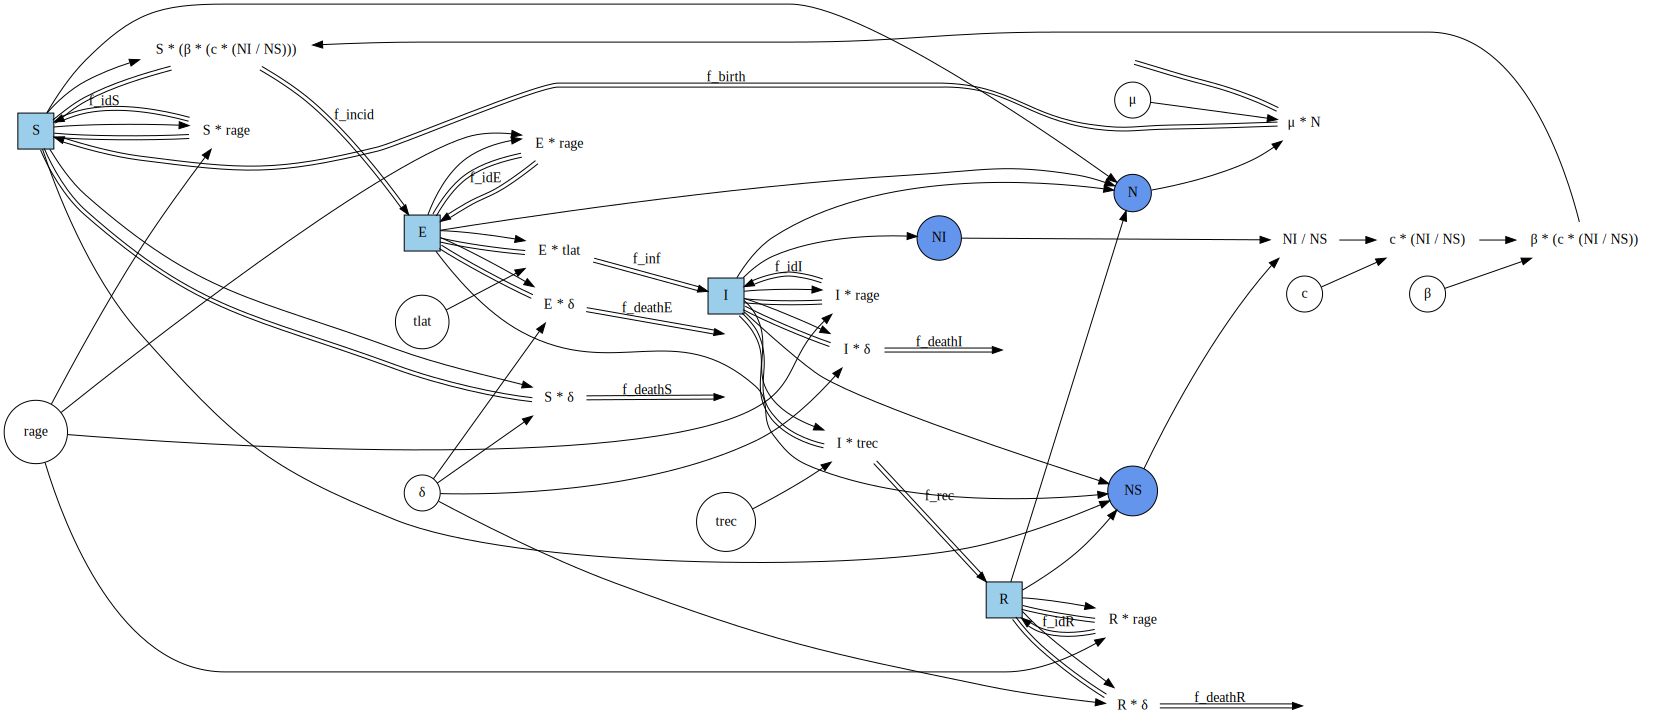

In [13]:
GraphF(dom(typed_aggregate_model))

## 1.3 define the sex structure diagram

In [14]:
seirm = @stock_and_flow begin
    :stocks
    Sm
    Em
    Im
    Rm

    :parameters
    μm
    βm
    tlatm
    trecm
    δm
    cm
    ragem

    :dynamic_variables
    v_birthm = μm * N
    v_infm = Em * tlatm
    v_deathEm = Em * δm
    v_recm = Im * trecm
    v_deathIm = Im * δm
    v_deathRm = Rm * δm
    v_deathSm = Sm * δm
    
    v_prevalencem = NIm / NSm # not entirely clear on how this interacts with other sex.
    v_meanInfectiousContactsPerSm = cm * v_prevalencem
    v_perSIncidenceRatem = βm * v_meanInfectiousContactsPerSm
    v_newInfectionsm = Sm * v_perSIncidenceRatem

    v_idSm = Sm * ragem
    v_idEm = Em * ragem
    v_idIm = Im * ragem
    v_idRm = Rm * ragem


    :flows
    CLOUD => f_birthm(v_birthm) => Sm
    Sm => f_incidm(v_newInfectionsm) => Em
    Sm => f_deathSm(v_deathSm) => CLOUD
    Em => f_infm(v_infm) => Im
    Em => f_deathEm(v_deathEm) => CLOUD
    Im => f_recm(v_recm) => Rm
    Im => f_deathIm(v_deathIm) => CLOUD
    Rm => f_deathRm(v_deathRm) => CLOUD

    Sm => f_idSm(v_idSm) => Sm
    Em => f_idEm(v_idEm) => Em
    Im => f_idIm(v_idIm) => Im
    Rm => f_idRm(v_idRm) => Rm

    :sums
    N = [Sm, Em, Im, Rm]
    NIm = [Im]
    NSm = [Sm, Em]



end;


seirf = @stock_and_flow begin
    :stocks
    Sf
    Ef
    If
    Rf

    :parameters
    μf
    βf
    tlatf
    trecf
    δf
    cf
    ragef

    :dynamic_variables
    v_birthf = μf * N
    v_inff = Ef * tlatf
    v_deathEf = Ef * δf
    v_recf = If * trecf
    v_deathIf = If * δf
    v_deathRf = Rf * δf
    v_deathSf = Sf * δf
    
    v_prevalencef = NIf / NSf # not entirely clear on how this interacts with other sex.
    v_meanInfectiousContactsPerSf = cf * v_prevalencef
    v_perSIncidenceRatef = βf * v_meanInfectiousContactsPerSf
    v_newInfectionsf = Sf * v_perSIncidenceRatef

    v_idSf = Sf * ragef
    v_idEf = Ef * ragef
    v_idIf = If * ragef
    v_idRf = Rf * ragef


    :flows
    CLOUD => f_birthf(v_birthf) => Sf
    Sf => f_incidf(v_newInfectionsf) => Ef
    Sf => f_deathSf(v_deathSf) => CLOUD
    Ef => f_inff(v_inff) => If
    Ef => f_deathEf(v_deathEf) => CLOUD
    If => f_recf(v_recf) => Rf
    If => f_deathIf(v_deathIf) => CLOUD
    Rf => f_deathRf(v_deathRf) => CLOUD

    Sf => f_idSf(v_idSf) => Sf
    Ef => f_idEf(v_idEf) => Ef
    If => f_idIf(v_idIf) => If
    Rf => f_idRf(v_idRf) => Rf

    :sums
    N = [Sf, Ef, If, Rf]
    NIf = [If]
    NSf = [Sf, Ef]



end;




In [15]:
N_foot = foot((), :N, ())
open_seirm = Open(seirm, N_foot);
open_seirf = Open(seirf, N_foot);

In [16]:
uwd_N_compose = @relation (N,) begin
    F(N)
    M(N)
end;


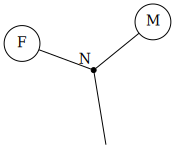

In [17]:
display_uwd(uwd_N_compose)

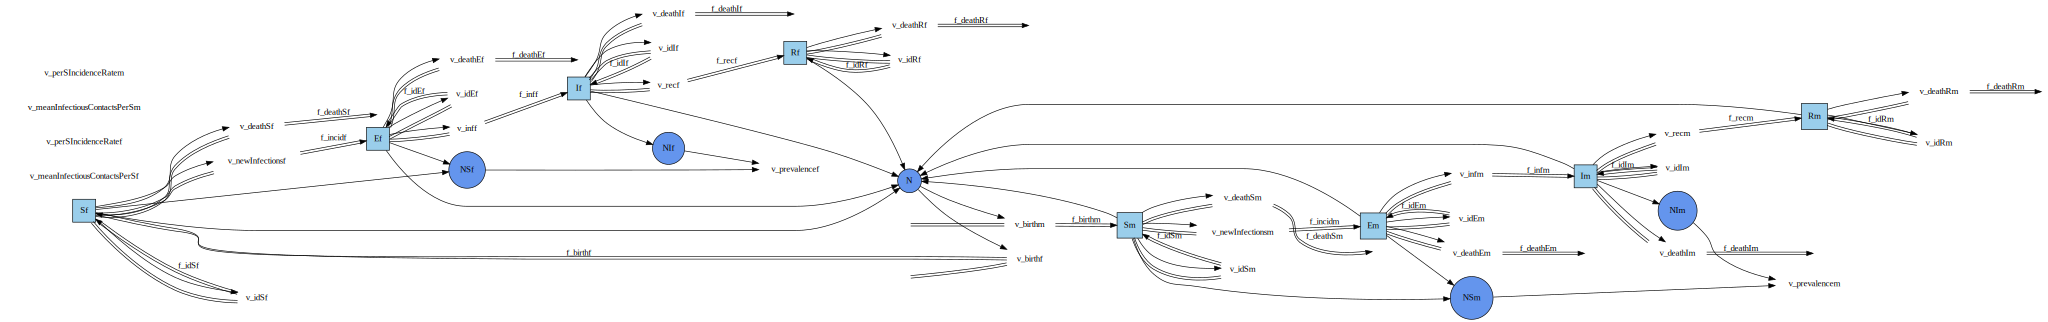

In [18]:
seirfm = oapply(uwd_N_compose, Dict(
    :F => open_seirf,
    :M => open_seirm
)) |> apex
Graph(seirfm)

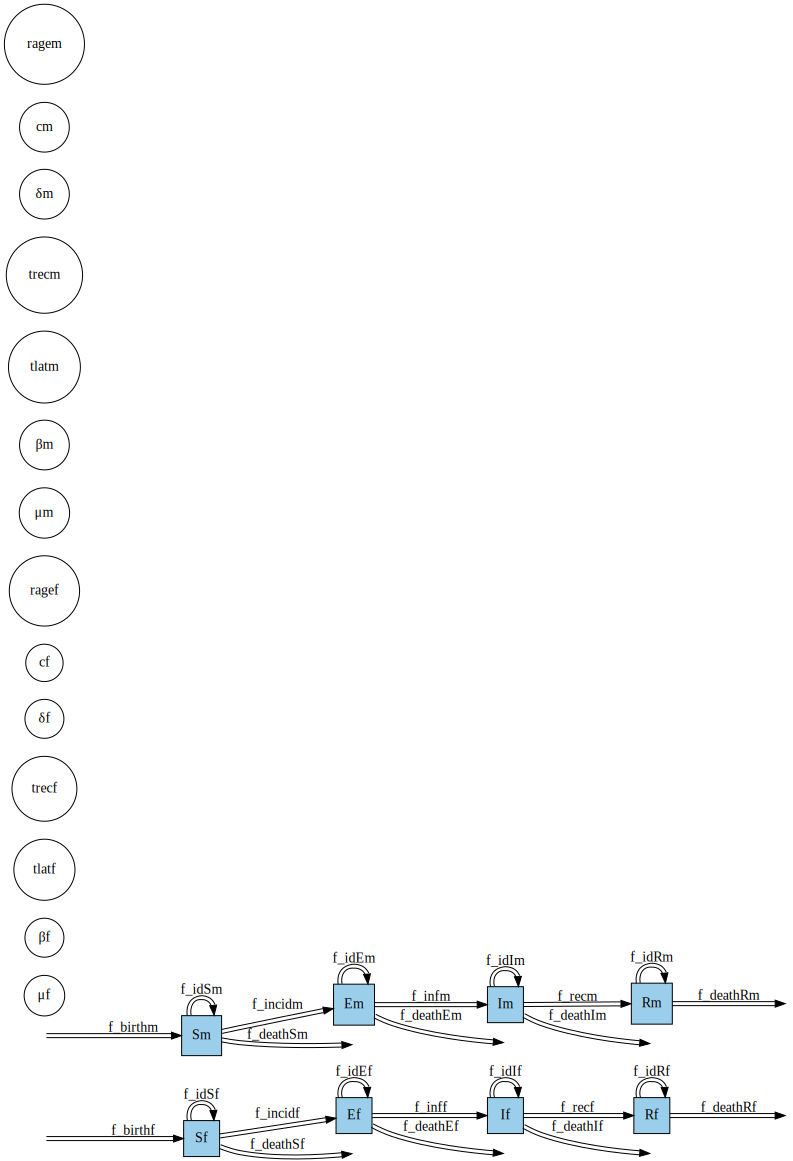

In [19]:
GraphF(seirfm, type="SF")

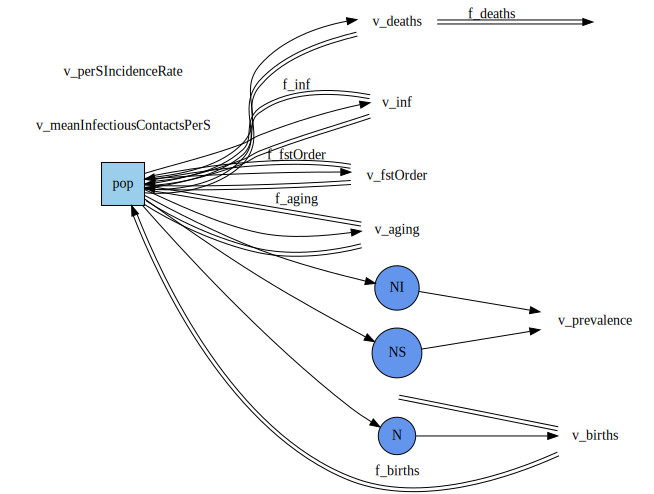

In [20]:
Graph(pop_type)

In [21]:

# Made aggressive use of helper functions for this one.
# Due to naturality, I only needed to directly define S, F, V, SV, and P, the rest can be inferred.
# in fact, in a lot of cases, we can go further than that and define even fewer.  Potentially only F.

seirfm_trans = ACSetTransformation(seirfm, pop_type_noname,
    S = [popstock, popstock, popstock, popstock, popstock, popstock, popstock, popstock], 
    F = [f_births, f_inf, f_deaths, f_fstOrder, f_deaths, f_fstOrder, f_deaths, f_deaths, f_aging, f_aging, f_aging, f_aging,
        f_births, f_inf, f_deaths, f_fstOrder, f_deaths, f_fstOrder, f_deaths, f_deaths, f_aging, f_aging, f_aging, f_aging],
    V = [v_births, v_fstOrder, v_deaths, v_fstOrder, v_deaths, v_deaths, v_deaths, v_prevalence, 
         v_meanInfectiousContactsPerS, v_perSIncidenceRate, v_inf, v_aging, v_aging, v_aging, v_aging, 
         v_births, v_fstOrder, v_deaths, v_fstOrder, v_deaths, v_deaths, v_deaths, v_prevalence, 
         v_meanInfectiousContactsPerS, v_perSIncidenceRate, v_inf, v_aging, v_aging, v_aging, v_aging],
    P = [p_μ, p_β, p_rFstOrder, p_rFstOrder, p_δ, p_c, p_rAge, p_μ, p_β, p_rFstOrder, p_rFstOrder, p_δ, p_c, p_rAge],
    SV = [N, NI, NS, NI, NS],
    I = [i_births, i_aging, i_inf, i_aging, i_fstOrder, i_aging, i_fstOrder, i_aging, i_births, i_aging, i_inf, i_aging, i_fstOrder, i_aging, i_fstOrder, i_aging],
    LV = [lv_fstOrder, lv_deaths, lv_fstOrder, lv_deaths, lv_deaths, lv_deaths, lv_inf, lv_aging, lv_aging, lv_aging, lv_aging, lv_fstOrder, lv_deaths, lv_fstOrder, lv_deaths, lv_deaths, lv_deaths, lv_inf, lv_aging, lv_aging, lv_aging, lv_aging],
    LS = [ls_N, ls_NS, ls_N, ls_NS, ls_N, ls_NI, ls_N, ls_N, ls_NS, ls_N, ls_NS, ls_N, ls_NI, ls_N],
    LVV = [lvv_prevalence, lvv_meanInfectiousContactsPerS, lvv_perSIncidenceRate, lvv_prevalence, lvv_meanInfectiousContactsPerS, lvv_perSIncidenceRate],
    LSV = [lsv_births, lsv_prevalence_NI, lsv_prevalence_NS, lsv_births, lsv_prevalence_NI, lsv_prevalence_NS],
    O = [o_inf, o_deaths, o_aging, o_fstOrder, o_deaths, o_aging, o_fstOrder, o_deaths, o_aging, o_deaths, o_aging, o_inf, o_deaths, o_aging, o_fstOrder, o_deaths, o_aging, o_fstOrder, o_deaths, o_aging, o_deaths, o_aging],
    LPV = [lpv_μ, lpv_rFstOrder, lpv_δ, lpv_rFstOrder, lpv_δ, lpv_δ, lpv_δ, lpv_c, lpv_β, lpv_rAge, lpv_rAge, lpv_rAge, lpv_rAge, lpv_μ, lpv_rFstOrder, lpv_δ, lpv_rFstOrder, lpv_δ, lpv_δ, lpv_δ, lpv_c, lpv_β, lpv_rAge, lpv_rAge, lpv_rAge, lpv_rAge],

    Name=name->nothing, Op=op->nothing, Position=pos->nothing


)

@assert is_natural(seirfm_trans)


In [22]:


stratify(typed_models...) = ob(pullback(collect(typed_models)))

typed_stratify(typed_models...) =
  compose(legs(pullback(collect(typed_models)))[1], typed_models[1]);
     


In [23]:
seir_sex = stratify()

LoadError: Empty list of legs but no apex given

In [24]:
S_sex_strata = @stock_and_flow begin
    :stocks
    M
    F

    :dynamic_variables
    
    v_birthsM
    v_idM
    v_agingM
    v_newInfectiousM
    v_deathsM


    v_birthsF
    v_idF
    v_agingF
    v_newInfectiousF
    v_deathsF

    :parameters # you need like 5 more dynamic variables fool.
    μM
    δM
    βM
    cM
    rFstOrderM
    rAgeM
    
    μF
    δF
    βF
    cF
    rFstOrderF
    rAgeF

    :flows
    
    CLOUD => f_birthsM(v_birthsM) => M
    M => f_deathsM(v_deathsM) => CLOUD
    M => f_infM(v_infM) => M
    M => f_fstOrderM(v_fstOrderM) => M
    M => f_agingM(v_agingM) => M
    
    CLOUD => f_birthsF(v_birthsF) => F
    F => f_deathsF(v_deathsF) => CLOUD
    F => f_infF(v_infF) => F
    F => f_fstOrderF(v_fstOrderF) => F
    F => f_agingF(v_agingF) => F
    
    :sums
    N
    NIM
    NSM
    NIF
    NSF
    
    
    
  

LoadError: syntax: "\" is not a unary operator